# **Introduction**

In this notebook, we explore different available Machine Learning techniques as well as Deep Leearning techniques for the task of Sentiment Classification. The data we used are from Amazon Fine Food Reviews data set extracted from [Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews). This notebook is the first part of our journey.


Since the dataset is quite voluminous (500k reviews), I've only imported 10% of the dataset. 

# **Importing Packages**

In [2]:
import os  # Get directory
import re
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns  # Pretty plots :)
import ipywidgets as widgets  # Interactive plot x)
import nltk
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# Set the theme
sns.set_theme()

# Print every output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Retrieve current directory
repo = os.getcwd()

In [3]:
# Load and check data
df = pd.read_csv(repo + '/Reviews_small.csv', index_col='Id')
df.head(3)  

# Check data types
df.info()

print('\n Shape of data', df.shape)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
14,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",2,2,4,1288915200,fresh and greasy!,good flavor! these came securely packed... the...
15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,1268352000,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57507 entries, 4 to 568442
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ProductId               57507 non-null  object
 1   UserId                  57507 non-null  object
 2   ProfileName             57506 non-null  object
 3   HelpfulnessNumerator    57507 non-null  int64 
 4   HelpfulnessDenominator  57507 non-null  int64 
 5   Score                   57507 non-null  int64 
 6   Time                    57507 non-null  int64 
 7   Summary                 57504 non-null  object
 8   Text                    57507 non-null  object
dtypes: int64(4), object(5)
memory usage: 4.4+ MB

 Shape of data (57507, 9)


The dataset contains ~50k reviews from Amazon, with 9 different columns : ProductId, UserId, ProfileName,... The column Score is our target column. Note that the column Score is **ordinal**. Our goal here is to predict the score of each reviews. It's a classification task.

The columns Helpxxx don't contain useful information for our task since they are given after the reviews have been made and not relevant to classify the reviews.

Recall that we want to predict the score of the item based on their reviews : texts or summaries. We can remove all the Id columns as well (after EDA).

# Clean up data

In this section, we will convert columns into their expected format, and remove the columns that we will not use, and remove empty values. 

In [4]:
# Modify data types Summary/ Text / Score
df.loc[:,'Summary'] = df['Summary'].astype('string')
df.loc[:,'Text'] = df['Text'].astype('string')

# Convert time to datetime format
print('\n Data after converting Time to datetime format')
df['Time'] = pd.to_datetime(df['Time'], unit='s')
df.head(3)

# Check percentage of missing values
df.isna().sum().sort_values(ascending=False)/df.shape[0]
# The missing values are less than 5%, we can safely remove them out
df.dropna(inplace=True)

# Remove helpxxx columns
df.drop(['HelpfulnessNumerator', 'HelpfulnessDenominator', 'ProfileName'], axis=1, inplace=True)

# Categorical/ Numerical features
cat = df.select_dtypes(include='O').columns
num = df.select_dtypes(exclude='O').columns


# Print out categorifal features/ numerical features
print('Categorical features are', cat.to_list())
print('Numerical features are', num.to_list())


 Data after converting Time to datetime format


,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...
14,B001GVISJM,A18ECVX2RJ7HUE,"willie ""roadie""",2,2,4,2010-11-05,fresh and greasy!,good flavor! these came securely packed... the...
15,B001GVISJM,A2MUGFV2TDQ47K,"Lynrie ""Oh HELL no""",4,5,5,2010-03-12,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...


Summary                   0.000052
ProfileName               0.000017
ProductId                 0.000000
UserId                    0.000000
HelpfulnessNumerator      0.000000
HelpfulnessDenominator    0.000000
Score                     0.000000
Time                      0.000000
Text                      0.000000
dtype: float64

Categorical features are ['ProductId', 'UserId']
Numerical features are ['Score', 'Time', 'Summary', 'Text']


# Description of data
 
 Our data set contains $\approx$ 50k observations, in which each observation is a review left by a customer on a product at a specific moment. The key access to the table is the Id column (unique). There are 9 features (columns) in the table, where each column is self-explanatory: 

    ProductId: helps to identify the product
    UserId: helps to identify the customer
    Profile Name: Name chosen by user (we will remove this column since we already had access to UserId, which is a better indentifier of each user. *We noticed that some different users can have the same ProfileName*)
    Summary: summarized version of the review
    Text: Detailed version of the review
    Score: Our targeted discrete feature, score from 1-5
    Time: The time of the review
    

Some observations are missing, but this number is minimal compared to the data size, therefore we removed them from the table.

It is also interesting to point out that the table doesn't consist of unique user giving reviews to an unique product. We can find one product being rated by different users, as well as one user giving reviews to different products (*number of UserId and ProductId are $\leq$ than number of observations*). This suggests us to explore if there's common points between the users or the products.

# Explanatory Data Analysis

Sometimes, it's overwhelming to start the data analysis task. Don't worry, I got you. When there's a new dataset. Instead of approaching it with statistics tools, just give in to all the first questions that you have in mind. Be curious, write down all the questions you'd like to ask your dataset before starting to code. It's always helped me to organize my workflow in EDA.

For instant, this dataset is quite self-explanatory, but also very mysterious, I'd love to know : 

1. What is the distribution of the scores ? Do we often have more good reviews than bad? (I expect that the reviews will be mostly good, since Amazon has a good reputation. If so, this may be problematic for us, because our predictor will perform poorly on the bad reviews).

2. The reviews are often short, and may contain emojis, excessive punctuation, poor grammars,... This means that we will need to clean up our reviews a little bit before doing any classification.

(Other not too important questions)



3. Do we have any groups of users who often give the same scores ? (Maybe someone who always gives good feedback ?)

4. What about our Products, do we have any good on average products, or bad on average products?



Those are my first questions in mind, let's try to aswer them one by one. How about you, do you have any additional ones ? 



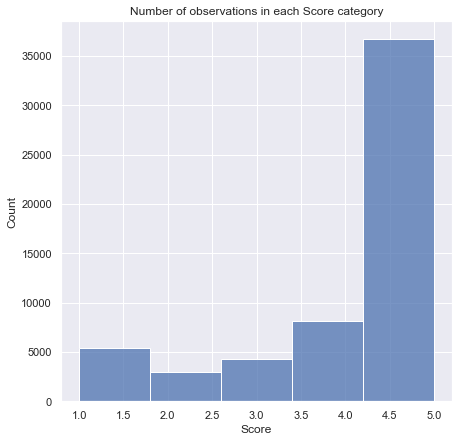

In [5]:
# Check how the scores are distributed
plt.figure(figsize=(7, 7))
sns.histplot(df['Score'], bins=5)
plt.title('Number of observations in each Score category')
plt.show();

We clearly have too many good reviews. This problem is called imbalanced class. We should be careful with our choice of models to deal with this. XGBOOST may help us to overcome this problem.

In [6]:
# Check our users and our products
df.groupby(['UserId'])['Score'].mean().head(3) # Check average scores given by each UserId
df.groupby(['UserId'])['Score'].count().head(3)  # Check number of reviews given per user

# Same but for product
df.groupby('ProductId')['Score'].mean().head(3)
df.groupby(['ProductId'])['Score'].count().head(3)

UserId
#oc-R12KPBODL2B5ZD    1.0
#oc-R1522DF2LUL4G1    1.0
#oc-R1BKC1B35FFB0     3.0
Name: Score, dtype: float64

UserId
#oc-R12KPBODL2B5ZD    1
#oc-R1522DF2LUL4G1    1
#oc-R1BKC1B35FFB0     1
Name: Score, dtype: int64

ProductId
141278509X    5.0
9376674501    5.0
B00004RBDW    4.0
Name: Score, dtype: float64

ProductId
141278509X     1
9376674501     1
B00004RBDW    31
Name: Score, dtype: int64

Some products have only 1 review, which may turn out to be hard for us to dermine the score. (When taking a small part of our original dataset, I've chosen to retrieve all reviews for a given product). Since we are interested only in the reviews, I will remove all Id & time columns out of our dataset.

The block code below allows us to look at the distribution of scores within each product.

In [7]:
%matplotlib widget
#Prod = widgets.Dropdown(options = sorted(list(set(df['ProductId']))))
Prod = list(set(df['ProductId']))
# Check if we have a set of products who always receive a certain score
def bar_plot(prod):
    print(f'ProductId {prod}')
    df_plot = df.groupby(['ProductId','Score'])['Score'].count().rename('Count', axis=1).reset_index()  
    df_plot = df_plot[df_plot['ProductId']==prod]
    df_plot['Count'].astype(int)
    
    plt.figure(figsize=(3, 3))
    sns.barplot(x='Score', y='Count', data=df_plot)
    plt.title('Distribution of score')
    plt.show();
    
widgets.interact(bar_plot,  prod=Prod)

interactive(children=(Dropdown(description='prod', options=('B000GLUEFO', 'B003BN7DLW', 'B001ELL6VG', 'B004G5Z…

<function __main__.bar_plot(prod)>

In [8]:
# Remove columns
df.drop(['ProductId', 'UserId', 'Time',], axis=1, inplace=True)

Handling raw texts is hard for any algorithm, therefor we need to have preliminary steps to clean up the raw string that we obtained from the reivews. Some of the questions that may help us to grab some general statistics are :

    1. How many unique words are there in the corpus provided?
    2. What are the most common strings ? 
    3. How do longest/shortest strings look like?
    4. Are there any weird expressions (url, wrongly spelled words,..)?

The cell below will help us to see what are most common strings in the corpus, and how do the longest/shortest strings look like

In [9]:
# Check number of words
train_string = ' '.join(df['Text'])
splits = train_string.split() 
print('Number of words (punctuation included):', len(splits))
print('Number of unique words(punct included):', len(set(splits)))

# Check the most common words
freq_splits = FreqDist(splits)
print('_'*80)
print('20 most common words \n', freq_splits.most_common(20), '\n')

# Shortest words
print('_'*80)
print("Shortest words")
short = set(s for s in splits if len(s)<4)
short = [(s, freq_splits[s]) for s in short]
short.sort(key=lambda x:x[1], reverse=True)
short[0:5]

#Longest words 
print('_'*80)
print("Longest words \n")
long = set(s for s in splits if len(s)>15)
long = [(s, freq_splits[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long[0:10]

Number of words (punctuation included): 4624839
Number of unique words(punct included): 157908
________________________________________________________________________________
20 most common words 
 [('the', 165079), ('I', 140564), ('and', 124758), ('a', 117139), ('to', 100209), ('of', 80150), ('is', 71985), ('it', 62511), ('for', 52915), ('in', 51696), ('this', 48668), ('that', 40457), ('my', 36761), ('have', 33898), ('with', 33741), ('but', 33586), ('are', 32588), ('was', 31804), ('not', 28913), ('you', 27911)] 

________________________________________________________________________________
Shortest words


[('the', 165079),
 ('I', 140564),
 ('and', 124758),
 ('a', 117139),
 ('to', 100209)]

________________________________________________________________________________
Longest words 



[('/>Unfortunately,', 49),
 ('disappointed.<br', 35),
 ('gastrointestinal', 24),
 ('preservatives.<br', 20),
 ('href="http://www.amazon.com/gp/product/B002IEZJMA">illy', 19),
 ('Frustration-Free', 17),
 ('over-the-counter', 15),
 ('health-conscious', 14),
 ('overpowering.<br', 13),
 ('expectations.<br', 13)]

**Remarks** 

* In the reviews' content, 20 most common words are among the stop words (I, the, and, to,...). These words don't bring additional information to the sentiment classification (at least in the context of product reviews, we do not intend to claim that the presence of a subject in a string will not imply additional emotion intensity). However, in product reviews, we assume that these words don't convey particular meaning to the reviews, therefore we will need to remove them later. 

*  Hyphenated words:  (ex: Gluten-free). If we tokenise on white space or punctuation, these strings will be split into separate words. For most cases, this will conserve the gist of the sentence. If we keep hyphenated words as they are, they won’t be as common and consequently removed as rare words. (We can compare the two strategies)

* There are words combined with other punctuation (some due to lack of space) ex:'preservatives..'. It would be good to separate these cases into separate words when tokenising. So probably tokenising based on white space or punctuation is a good idea.

* There are websites addresses that we will need to remove

* There are wrongly spelled words that repeat the same character more than twice: 'consumption......'

The function below will focus on finding specific expressions in our corpus.

In [10]:
def find_pattern(pattern, words, freq):
    """ 
    Input : 
    pattern : str of patterns we want to search for
    words : list of words
    freq : the frency Function which takes a list of tupples containing matched string and their frequency"""
    
    # Match patterns
    compiled_pattern = re.compile(pattern)
    matches = [w for w in words if compiled_pattern.search(w)]

    # Display proportion of matcheds
    print(len(matches), 
          'words matched, which is {:.2%} of total'.format(len(matches)/len(words)))
    
    # Create list of tupples
    res = [(w, freq[w]) for w in set(matches)]
    res.sort(key=lambda x:x[1], reverse=True)
    print(f'Sample of patterns searched {res[0:10]} \n')

# Find hltml tags
find_pattern(r'/?>?w*<|/>', splits, freq_splits)

# Find numbers
find_pattern(r'\d', splits, freq_splits)

# Find Hyphenated words
find_pattern(r'\w+-+\w+', splits, freq_splits)

# Find 'href=' patterns
find_pattern(r'href\=', splits, freq_splits)

106842 words matched, which is 2.31% of total
Sample of patterns searched [('/><br', 26219), ('/>I', 5399), ('/>The', 2616), ('<a', 1164), ('/>This', 1131), ('/>My', 797), ('it.<br', 794), ('/>', 742), ('/>If', 740), ('/>It', 658)] 

51981 words matched, which is 1.12% of total
Sample of patterns searched [('2', 3336), ('3', 2736), ('5', 2154), ('4', 1995), ('1', 1679), ('6', 1388), ('10', 1056), ('12', 966), ('8', 816), ('100', 684)] 

23535 words matched, which is 0.51% of total
Sample of patterns searched [('gluten-free', 314), ('K-Cups', 302), ('k-cups', 299), ('K-cups', 296), ('K-cup', 258), ('K-Cup', 250), ('k-cup', 240), ('2-3', 158), ('sugar-free', 132), ('3-4', 112)] 

1571 words matched, which is 0.03% of total
Sample of patterns searched [('href="http://www.amazon.com/gp/product/B002IEZJMA">illy', 19), ('href="http://www.amazon.com/gp/product/B0029XDZIK">Coffee', 12), ('href="http://www.amazon.com/gp/product/B000AQPMHA">Keurig', 9), ('href="http://www.amazon.com/gp/product/B

In [11]:
def find_repeatly_spelled(word):
    """Find words that contain a same character 3+ times in a row.
        Return bool
    """
    is_wrongly_spelled = False
    for i, letter in enumerate(word):
        if i > 1:
            if word[i] == word[i-1] == word[i-2] and word[i].isalpha():
                is_wrongly_spelled = True
                break
    return is_wrongly_spelled


# List of repeatedly spelled words
list_repeatly_spelled = [w for w in splits if find_repeatly_spelled(w)]

# Print out percentage
print('Percentage of wrongly spelled words')
print('{} strings, that is {:.2%} of total'.format(len(list_repeatly_spelled), 
                                         len(list_repeatly_spelled)/len(splits)))
outlaw_freq = [(w, freq_splits[w]) for w in set(list_repeatly_spelled)]
outlaw_freq.sort(key=lambda x:x[1], reverse=True)
print(f'Examples of weird expressions {outlaw_freq[0:10]}')

Percentage of wrongly spelled words
2723 strings, that is 0.06% of total
Examples of weird expressions [('soooo', 86), ('sooo', 75), ('sooooo', 45), ('soooooo', 25), ('href="http://www.amazon.com/gp/product/B002IEZJMA">illy', 19), ('Soooo', 13), ('href="http://www.amazon.com/gp/product/B0029XDZIK">Coffee', 12), ('SOOO', 11), ('href="http://www.amazon.com/gp/product/B000AQPMHA">Keurig', 9), ('href="http://www.amazon.com/gp/product/B004779XNW">Green', 9)]


**Remarks**

* The number of words where there are html tags are of 2% of the train data set. This will not be a problem since later we will tokenise on whitespace and punctuation (including special characters). These words will "appear" normal. Note that words such as "br" should also be included in our stopwords => We need to expand our list of stopwords

* There are some numbers in the reviews, but since they only take 1% of the train data, and in most case, they don't convey a particular sentiment, we will also not take them into account when tokenizing => We will remove the numbers when cleaning the text

* The percentage of hyphenated words are very few ($\leq$ 2%) if they are treated as one word, and they don't increase the tdidf matrix size, then we will include hyphenated words in our analysis, if they increase the matrix size, we will remove them as well.

Below is the function to clean the text.


In [12]:
# Add html words tag into stop words collection
stop_words = stopwords.words("english")
stop_words.extend(['br', 'href'])

In [21]:
def preprocess_string(string):
    # Lower case
    string = string.lower()
    
    # Remove html tags    
    html_tag = re.compile('<.*?>')
    string = re.sub(html_tag, ' ', string)

    # Remove url
    string = re.sub(r'http\S+', ' ', string) 
    
    # Remove single / double characters
    string = re.sub(r'\b\w{1,2}\b', ' ', string)
    
    # Remove words that are in stop words
    string = ' '.join(w for w in string.split() if w not in stop_words)
    
     # Remove word that starts with "aa"
    string = re.sub(r'^aa\w+', ' ', string)

    # Remove word that have 3+ consecutive words for ex: wooow
    string = re.sub(r'\b\w*(\w)\1\1\w*', ' ', string)
    
    # Remove digits
    string = re.sub(r'\d', ' ', string)
    
    # Remove extra white space
    string = re.sub(r'[\s]+', ' ', string) 

    # Remove punctuation
    string = re.sub(r'[^\w\s]',' ', string)
    
    # Replace '-' with a space 
    string = re.sub(r"\-", ' ', string) #

    # Remove extra ''
    string = re.sub(r"\'+", '', string) 

    
    return(string)

def lemmatize_string(string):
    lem=WordNetLemmatizer()
    prep_string = preprocess_string(string)
    string = ' '.join(lem.lemmatize(w, pos='v') for w in prep_string.split())
    return(string)

In [14]:
# Clean the text
df['Summary_prep'] = df['Summary'].apply(lemmatize_string)
print('Done cleaning Summary!'+'.'*80)

df['Text_prep'] = df['Text'].apply(lemmatize_string)
print('Done cleaning Text!'+'.'*80)

# Export cleaned data
df.to_csv(repo+'/Reviews_cleaned.csv', encoding='utf-8', index=False)

Done cleaning Summary!................................................................................
Done cleaning Text!................................................................................


In [15]:
# Prepare data set
# Import cleaned data
df_new = pd.read_csv(repo + '/Reviews_cleaned.csv')
df_new.dropna(inplace=True)

# Load and check data
df_new.head(3)  

# Check data types
df_new.info()

print('\n Shape of data', df_new.shape)

,Score,Summary,Text,Summary_prep,Text_prep
0,2,Cough Medicine,If you are looking for the secret ingredient i...,cough medicine,look secret ingredient robitussin believe find...
1,4,fresh and greasy!,good flavor! these came securely packed... the...,fresh greasy,good flavor come securely pack fresh delicious...
2,5,Strawberry Twizzlers - Yummy,The Strawberry Twizzlers are my guilty pleasur...,strawberry twizzlers yummy,strawberry twizzlers guilty pleasure yummy six...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57029 entries, 0 to 57502
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Score         57029 non-null  int64 
 1   Summary       57029 non-null  object
 2   Text          57029 non-null  object
 3   Summary_prep  57029 non-null  object
 4   Text_prep     57029 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.6+ MB

 Shape of data (57029, 5)


In [16]:
# Check the cleaned text
import random
loc = random.randint(0, len(df_new))
print('Original text...')
print(list(df_new.loc[loc, ['Text']]))
print('Cleaned text...')
print(list(df_new.loc[loc, ['Text_prep']]))

Original text...
['Cats loved these "greenies".  They know when I\'m opening the package and come running.  Also the shipper didn\'t waste any time getting this out to me!  Thanks!!']
Cleaned text...
['cat love greenies know open package come run also shipper didn waste time get thank']


In [17]:
# Check number of words
train_string = ' '.join(df_new['Text_prep'])
splits = train_string.split() 
print('Number of words (punctuation included):', len(splits))
print('Number of unique words(punct included):', len(set(splits)))

# Check the most common words
freq_splits = FreqDist(splits)
print('_'*80)
print('20 most common words \n', freq_splits.most_common(20), '\n')

# Shortest words
print('_'*80)
print("Shortest words")
short = set(s for s in splits if len(s)<4)
short = [(s, freq_splits[s]) for s in short]
short.sort(key=lambda x:x[1], reverse=True)
short[0:5]

#Longest words 
print('_'*80)
print("Longest words \n")
long = set(s for s in splits if len(s)>15)
long = [(s, freq_splits[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long[0:10]

# Find hltml tags
find_pattern(r'/?>?w*<|/>', splits, freq_splits)

# Find numbers
find_pattern(r'\d', splits, freq_splits)

# Find Hyphenated words
find_pattern(r'\w+-+\w+', splits, freq_splits)

# Find 'href=' patterns
find_pattern(r'href\=', splits, freq_splits)

Number of words (punctuation included): 2325128
Number of unique words(punct included): 40169
________________________________________________________________________________
20 most common words 
 [('like', 28666), ('taste', 26252), ('flavor', 21769), ('good', 20160), ('get', 18601), ('love', 18589), ('one', 17768), ('make', 17541), ('try', 17082), ('coffee', 16581), ('great', 16558), ('use', 16412), ('buy', 15644), ('tea', 15274), ('product', 14528), ('food', 14104), ('find', 13568), ('eat', 13028), ('would', 12630), ('dog', 10892)] 

________________________________________________________________________________
Shortest words


[('get', 18601),
 ('one', 17768),
 ('try', 17082),
 ('use', 16412),
 ('buy', 15644)]

________________________________________________________________________________
Longest words 



[('gastrointestinal', 24),
 ('enthusiastically', 20),
 ('strawberrybanana', 15),
 ('vitaminsminerals', 8),
 ('indistinguishable', 8),
 ('misrepresentation', 7),
 ('sucralosesplenda', 5),
 ('itchingbitinglicking', 5),
 ('hexametaphosphate', 5),
 ('dogfoodanalysiscom', 5)]

0 words matched, which is 0.00% of total
Sample of patterns searched [] 

0 words matched, which is 0.00% of total
Sample of patterns searched [] 

0 words matched, which is 0.00% of total
Sample of patterns searched [] 

0 words matched, which is 0.00% of total
Sample of patterns searched [] 



In [18]:
# Check number of words (for feature Summary)
train_string = ' '.join(df_new['Summary_prep'])
splits = train_string.split() 
print('Number of words (punctuation included):', len(splits))
print('Number of unique words(punct included):', len(set(splits)))

# Check the most common words
freq_splits = FreqDist(splits)
print('_'*80)
print('20 most common words \n', freq_splits.most_common(20), '\n')

# Shortest words
print('_'*80)
print("Shortest words")
short = set(s for s in splits if len(s)<4)
short = [(s, freq_splits[s]) for s in short]
short.sort(key=lambda x:x[1], reverse=True)
short[0:5]

#Longest words 
print('_'*80)
print("Longest words \n")
long = set(s for s in splits if len(s)>15)
long = [(s, freq_splits[s]) for s in long]
long.sort(key=lambda x:x[1], reverse=True)
long[0:10]

# Find hltml tags
find_pattern(r'/?>?w*<|/>', splits, freq_splits)

# Find numbers
find_pattern(r'\d', splits, freq_splits)

# Find Hyphenated words
find_pattern(r'\w+-+\w+', splits, freq_splits)

# Find 'href=' patterns
find_pattern(r'href\=', splits, freq_splits)

Number of words (punctuation included): 165819
Number of unique words(punct included): 10095
________________________________________________________________________________
20 most common words 
 [('great', 7491), ('good', 5139), ('love', 3986), ('best', 3412), ('taste', 3069), ('coffee', 2627), ('tea', 2438), ('dog', 2219), ('product', 1945), ('delicious', 1901), ('flavor', 1681), ('like', 1527), ('food', 1482), ('cat', 1367), ('excellent', 1308), ('price', 1165), ('tasty', 1164), ('yummy', 1111), ('treat', 1090), ('snack', 1018)] 

________________________________________________________________________________
Shortest words


[('tea', 2438), ('dog', 2219), ('cat', 1367), ('cup', 828), ('buy', 609)]

________________________________________________________________________________
Longest words 



[('tastingeffective', 3),
 ('misrepresentation', 2),
 ('chemicalspreservatives', 2),
 ('thebestcoffeeever', 2),
 ('strawberrybanana', 2),
 ('makingvanillacom', 1),
 ('bresaolabundnerfleish', 1),
 ('alphisnumberonefan', 1),
 ('sebclarityconnectcom', 1),
 ('lovelovelovelove', 1)]

0 words matched, which is 0.00% of total
Sample of patterns searched [] 

0 words matched, which is 0.00% of total
Sample of patterns searched [] 

0 words matched, which is 0.00% of total
Sample of patterns searched [] 

0 words matched, which is 0.00% of total
Sample of patterns searched [] 



# **Split into train test set**

Next, we will split the cleaned data into train (90%) and test set(10%). We will take 20% of the train data to be validation set. Here we shouldn't use random split as usual, since our score column contains mostly 5 stars ratings. We should instead split the train and test set accordingly to the column Score.

In [19]:
y = df_new['Score'].astype('category')
df_text = df_new.drop(['Score'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(df_text, y, stratify=y, 
                                                    test_size=0.1, random_state=0)
# Reset index for train data
x_train.reset_index(inplace=True, drop=True)
y_train = y_train.reset_index(drop=True)

# Create validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, 
                                                test_size=0.2, random_state=0)

# Reset index for train data
x_train.reset_index(inplace=True, drop=True)
y_train = y_train.reset_index(drop=True)

# Reset index for val data
x_val.reset_index(inplace=True, drop=True)
y_val = y_val.reset_index(drop=True)

# Reset index for test data
x_test.reset_index(inplace=True, drop=True)
y_test = y_test.reset_index(drop=True)


# Check distribution of Score in y_train / y_test
plt.figure(figsize=(5, 5))
sns.countplot(y_train, color='blue', alpha=0.5, label='train data')
sns.countplot(y_test, color='red', alpha=0.5, label='test data')
plt.legend()
plt.title('Number of observations in each Score category')
plt.show();

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

C:\Users\ttran\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


In [20]:
# Export train, val and test set
df_train.to_csv(repo+'/train.csv', encoding='utf-8', index=False)
y_train.to_csv(repo+'/train_labels.csv', encoding='utf-8', index=False)

df_val.to_csv(repo+'/valid.csv', encoding='utf-8', index=False)
y_val.to_csv(repo+'/valid_labels.csv', encoding='utf-8', index=False)

df_test.to_csv(repo+'/test.csv', encoding='utf-8', index=False)
y_test.to_csv(repo+'/test_labels.csv', encoding='utf-8', index=False)

NameError: name 'df_train' is not defined